Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

- [2024/03/14]   
  No need to restart when you update the scratch library

To do
- Update dimensional reduction section with a loss function plot

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import csv
import pandas as pd


from typing import List, Dict, Callable, NamedTuple, Optional
from collections import Counter, namedtuple

from dataclasses import dataclass 
from dateutil.parser import parse

from scratch.probability import Probability as prob
from scratch.statistics import Statistics as stats

from scratch.linear_algebra import Vector
from scratch.linear_algebra import LinearAlgebra as la
from scratch.gradient_descent import GradientDescent as gd
from tqdm.notebook import trange

In [29]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

In [30]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploring Your Data

### Exploring One-Dimensional Data

Make several functions to do *data bucketing*

In [31]:
def bucketize(point: float, bucket_size: float) -> float:
  """Floo the point to the next lower multiple of bucket_size""" 
  return bucket_size * np.floor(point / bucket_size)


def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
  """Buckets the points and counts how many in each bucket""" 
  return Counter(bucketize(point, bucket_size) for point in points)


def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
  fig, ax = plt.subplots()
  
  histogram = make_histogram(points, bucket_size)

  ax.bar(histogram.keys(), histogram.values(), width=bucket_size)
  ax.set_title(title)

  plt.show(fig)

Test the above declared functions

In [32]:
seed = 2023_03_30
rng = np.random.default_rng(seed)

# uniform between -100 and 100
uniform = 200 * rng.random(10_000) - 100 

# normal distribution with mean 0, standard deviation 57
normal = [57 * prob.inverse_normal_cdf(rng.random())
          for _ in range(10_000)]

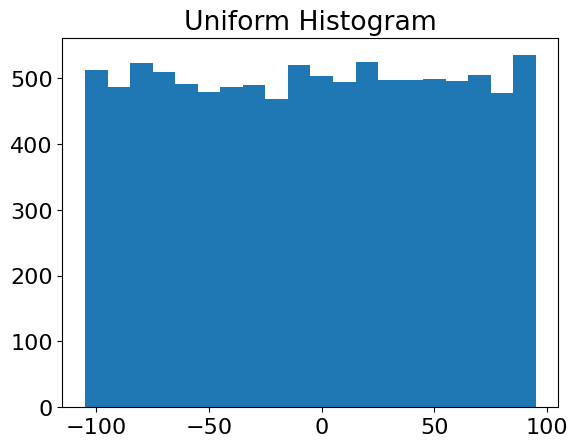

In [33]:
plot_histogram(uniform, 10, "Uniform Histogram")

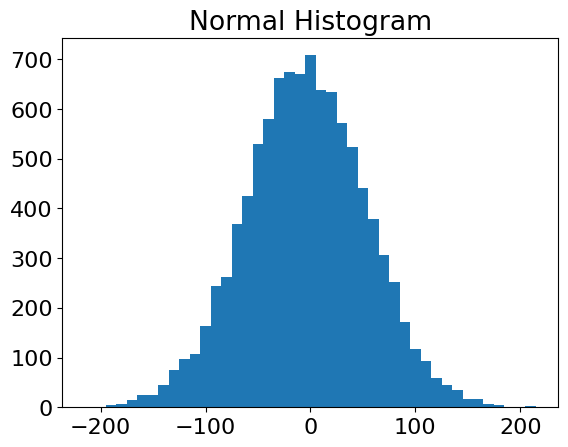

In [34]:
plot_histogram(normal, 10, "Normal Histogram")

### Two Dimensions

Using scatter plot, we can understand interplay between points
in two dimensions dataset

In [35]:
# Declare a function to generate fake dataset

def random_normal(rng: float) -> float:
  """Returns a random draw from a standard normal distribution""" 
  return prob.inverse_normal_cdf(rng.random())

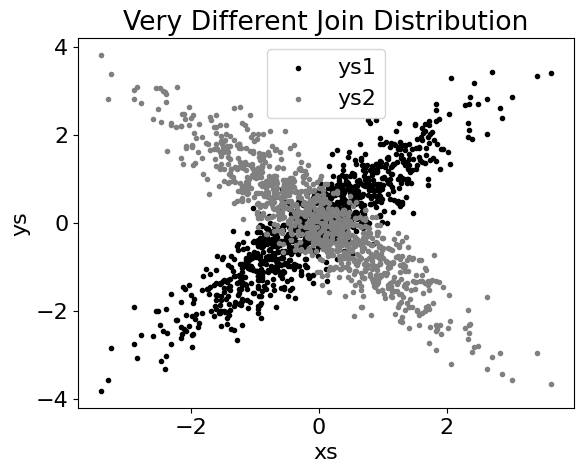

In [36]:
# Generate fake dataset and plot it

fig, ax = plt.subplots()

seed = 2023_03_30
rng = np.random.default_rng(seed)
xs = [random_normal(rng) for _ in range(1_000)]
ys1 = [ x + random_normal(rng) / 2 for x in xs]
ys2 = [-x + random_normal(rng) / 2 for x in xs]

ax.scatter(xs, ys1, marker='.', color='k', label='ys1')
ax.scatter(xs, ys2, marker='.', color='gray', label='ys2')

ax.set_xlabel('xs')
ax.set_ylabel('ys')

ax.legend(loc=9)

ax.set_title("Very Different Join Distribution")

plt.show(fig)

In [37]:
# Compute the correlation
print(stats.correlation(xs, ys1))
print(stats.correlation(xs, ys2))

0.9038420031209764
-0.9000485145506606


### Many Dimensions

We want to know how each dimension relates to the another dimension

In [38]:
Vector = List[float]
Matrix = List[List[float]]

def correlation_ij(data: List[Vector]) -> Callable[[int, int], float]: 
  return stats.correlation

def correlation_matrix(data: List[Vector]) -> Matrix:
  """
  Returns the len(data) x len(data) matrix whose (i,j)-th entry
  is the correlation between data[i] and data[j]
  """ 

  return la.make_matrix(len(data), len(data), correlation_ij(data))


Create a scatter plot matrix

In [39]:
seed = 2023_03_30
rng = np.random.default_rng(seed)

vec1 = rng.normal(0, 1, 100) 
vec2 = rng.normal(0, 1, 100) - vec1
vec3 = rng.normal(0, 1, 100) - vec1
vec4 = [rng.choice([0, 6]) for _ in range(100)]

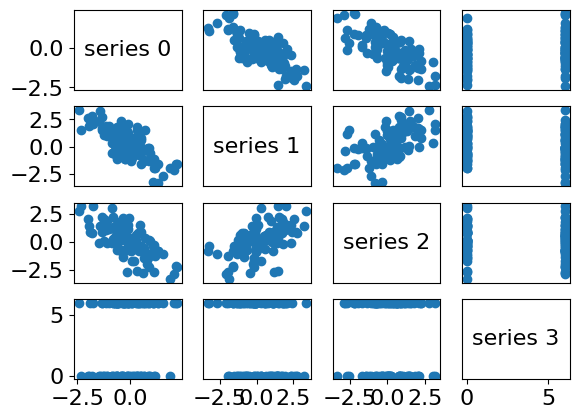

In [40]:
corr_data = [vec1, vec2, vec3, vec4]
# corr_data is a list of four 100-d vectors
num_vectors = len(corr_data)


fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
  for j in range(num_vectors):
    # Scatter column_j on the x-axis vs. column_i on the y-axis
    if i != j:
      ax[i][j].scatter(corr_data[j], corr_data[i])

    # unless i == j, in which case show the series name
    else:
      ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                        xycoords='axes fraction',
                        ha="center", va="center")

    # Then hide axis labels except left and bottom charts
    if i < num_vectors - 1:
      ax[i][j].xaxis.set_visible(False)
    
    if j > 0: 
      ax[i][j].yaxis.set_visible(False)
  
# Fix the bottom-right and top-left axis labels, which are wrong
# because their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())


plt.show(fig)

## Using NamedTuples

Using dictionary, but it is error-prone when accesing it 
with typo key (adding a new pair of key and val)


In [41]:
stock_price = {
  "closing_price": 145.31,
  "date": datetime.date(2023, 3, 1),
  "symbol": "AAPL"}

stock_price

{'closing_price': 145.31, 'date': datetime.date(2023, 3, 1), 'symbol': 'AAPL'}

In [42]:
# An alternative to dict using namedtuple

StockPrice = namedtuple(
  'StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2023, 3, 1), 246.27)

price

StockPrice(symbol='MSFT', date=datetime.date(2023, 3, 1), closing_price=246.27)

The following class will solve type annotation issue

In [43]:
class StockPrice(NamedTuple):
  symbol: str 
  date: datetime.date 
  closing_price: float 

  def is_high_tech(self) -> bool:
    """It's a class, so we can add methods to""" 
    return self.symbol in ["MSFT", "GOOG", "FB", "AMZN", "AAPL"]


price = StockPrice("MSFT", datetime.date(2023, 3, 1), 246.27)
price

StockPrice(symbol='MSFT', date=datetime.date(2023, 3, 1), closing_price=246.27)

Runnin the following code, you will get an attribute error

```py
price.closing_price *= 2    # We can't change the instance's value
```

```
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
/home/henokh/Documents/job-related/024 - SI ITK/ITK/Courses/AK-201-426-data-science/remote-repo/ch-10.ipynb Cell 28 in <cell line: 1>()
----> 1 price.closing_price *= 2

AttributeError: can't set attribute
```

## Dataclasses

A (sort of) mutable version of `NamedTuple`.
We prefer to use `NamedTuple` because we want to remove
the error-prone when we accidentally set the attribute values

In [44]:
@dataclass
class StockPrice2(object):
  symbol: str
  date: datetime.date 
  closing_price: float 

  def is_high_tech(self) -> bool:
    """It's a class, so we can add methods to""" 
    return self.symbol in ["MSFT", "GOOG", "FB", "AMZN", "AAPL"]


price2 = StockPrice2("MSFT", datetime.date(2023, 3, 1), 246.27)
price

StockPrice(symbol='MSFT', date=datetime.date(2023, 3, 1), closing_price=246.27)

In [45]:
price2.closing_price *= 2       # We can change using dataclass
price2

StockPrice2(symbol='MSFT', date=datetime.date(2023, 3, 1), closing_price=492.54)

## Cleaning and Munging

In [46]:
def parse_row(row: List[str]) -> StockPrice:
  symbol, date, closing_price = row 
  return StockPrice(symbol=symbol, date=parse(date).date(), 
                    closing_price=float(closing_price))

# Now test our function, but we falsely input the closing_price
# using a string
stock = parse_row(["MSFT", "2023-03-01", "246.27"])
stock

StockPrice(symbol='MSFT', date=datetime.date(2023, 3, 1), closing_price=246.27)

We put a bad example by using a string that does not represent
floating point number

In [47]:
def try_parse_row(row: List[str]) -> Optional[StockPrice]:
  symbol, date_, closing_price_ = row

  # Stock symbol should be all capital letters
  if not re.match(r"^[A-Z]+$", symbol):
    return None

  try:
    date = parse(date_).date()
  except ValueError:
    return None

  try:
    closing_price = float(closing_price_)
  except ValueError:
    return None

  return StockPrice(symbol, date, closing_price)


# A correct input
print(try_parse_row(["MSFT", "2023-03-01", "246.27"]))

# Should return None for errors
print(try_parse_row(["MSFT0", "2023-03-01", "246.27"]))
print(try_parse_row(["MSFT", "2023-03--01", "246.27"]))
print(try_parse_row(["MSFT", "2023-03-01", "x"]))

StockPrice(symbol='MSFT', date=datetime.date(2023, 3, 1), closing_price=246.27)
None
None
None


## Manipulating Data

## Rescaling

## An Aside: tqdm

## Dimensionality Reduction

In [48]:
df = pd.read_csv("./datasets/dim-reduc-2d.csv", header=None)
df

,0,1
0,20.966678,-13.113808
1,22.771991,-19.889089
2,25.668710,-11.995600
3,18.001979,-18.198919
4,21.396740,-10.889313
...,...,...
94,22.974620,-10.617116
95,34.632712,-9.261824
96,34.704251,-6.963075
97,15.656395,-17.219696


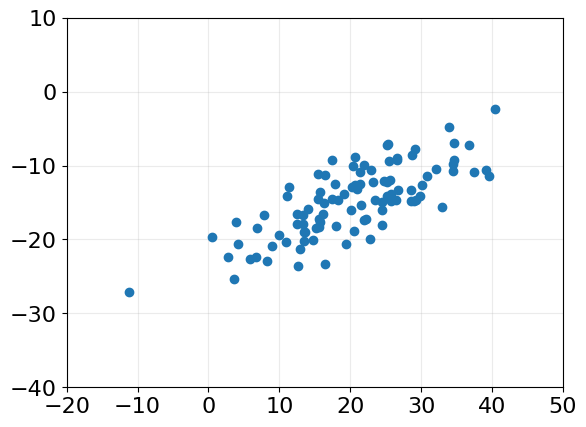

In [49]:
fig, ax = plt.subplots()

ax.plot(df[0], df[1], linestyle="None", marker="o")

ax.set_xlim([-20, 50])
ax.set_ylim([-40, 10])
ax.grid("on")
plt.show(fig)

If we look at the above data, we can clearly see that the most of the variation   
of the data does not correspond to either the $x$-axis  or the $y$-axis.   
Using a technique that is called _principle component analysis_ can extract   
one or more dimensional that capture as much of the variation in the data
as possible

$$
  \vec{w}_{n+1} = \vec{w}_n + \gamma \nabla f(\vec{w}_n)
$$

Directional variance
$$
\begin{align*}
  f(\vec{w}) 
    &= \sum_{i=1}^n \left(\vec{w} \cdot (\vec{x}_i - \vec{\mu})\right)^2 \\
    &= \sum_{i=1}^n 
      \left(
      \begin{bmatrix} w_1 & w_2 \end{bmatrix} \cdot
      \begin{bmatrix} x_{i, 1} - \mu_1 & x_{i, 2} \mu_2 \end{bmatrix} \\
      \right)^2 \\
    &= \sum_{i=1}^n 
      \left(w_1(x_{i, 1} - \mu_1) + w_2 (x_{i, 2} - \mu_2)\right)^2
\end{align*}
$$

In our dataset, $\vec{x}_i = (x_{i, 1}, \,\,x_{i, 2})$. And $\vec{\mu}$
is the vector mean across the dataset
$$
  \vec{\mu} = (\mu_1, \mu_2) = \left(\frac{1}{n}\sum_{i=1}^n x_{i, 1}, \,\,
                    \frac{1}{n}\sum_{i=1}^n x_{i, 2}\right)
$$
And $\vec{w}$ is the unit direction that we want to find $\vec{w} = (w_1, w_2)$

Then we have the gradient of directional variance
$$
\begin{align*}
  \nabla f(\vec{w}) 
    &= \left(\frac{\partial f(\vec{w})}{\partial w_1}, 
            \frac{\partial f(\vec{w})}{\partial w_2}\right)^\mathsf{T} \\
    &= \begin{bmatrix}
      \dfrac{\partial }{\partial w_1} \left( 
        \displaystyle\sum_{i=1}^n 
          \left(w_1(x_{i, 1} - \mu_1) + w_2(x_{i, 2} - \mu_2)\right)^2 \right) \\[12pt]
      \dfrac{\partial}{ \partial w_2} \left(
        \displaystyle\sum_{i=1}^n 
          \left(w_1(x_{i, 1} - \mu_1) + w_2(x_{i, 2} - \mu_2)\right)^2 \right) 
      \end{bmatrix} \\
    &= \begin{bmatrix}
      \dfrac{\partial }{\partial w_1} \left( 
        \displaystyle\sum_{i=1}^n 
          \left(w_1 v_{i, 1} + w_2 v_{i, 2}\right)^2 \right) \\[12pt]
      \dfrac{\partial}{ \partial w_2} \left(
        \displaystyle\sum_{i=1}^n 
          \left(w_1 v_{i, 1} + w_2 v_{i, 2}\right)^2 \right) 
      \end{bmatrix} \\
    &= \begin{bmatrix}
       \displaystyle\sum_{i=1}^n 
          2 \left(w_1 v_{i, 1} + w_2 v_{i, 2}\right) v_{i, 1} \\[12pt]
        \displaystyle\sum_{i=1}^n 
          2 \left(w_1 v_{i, 1} + w_2 v_{i, 2}\right) v_{i, 2}
      \end{bmatrix} \\
    &= \begin{bmatrix}
       \displaystyle\sum_{i=1}^n 
          2 \left(\vec{w} \cdot \vec{v}_i\right) v_{i, 1} \\[12pt]
        \displaystyle\sum_{i=1}^n 
          2 \left(\vec{w} \cdot \vec{v}_i\right) v_{i, 2}
      \end{bmatrix} \\
\end{align*}
$$

In [50]:
def de_mean(data: List[Vector]) -> List[Vector]:
  """Recenters the data to have mean 0 in every dimension"""
  mean = la.vector_mean(data)
  return [la.subtract(vector, mean) for vector in data]

In [51]:
def direction(w: Vector) -> Vector:
  mag = la.magnitude(w)
  return [w_i / mag for w_i in w]

In [52]:
def directional_variance(data: List[Vector], w: Vector) -> float:
  """Returns the variance of x in the direction of w""" 
  w_dir = direction(w)
  return sum(la.dot(v, w_dir)**2 for v in data)

In [56]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
  """The gradient of directional variance with respect to w"""
  w_dir = direction(w)
  return [sum(2 * la.dot(v, w_dir) * v[i] for v in data)
          for i in range(len(w))]

In [65]:
def first_principal_component(data: List[Vector], n: int = 100,
                              step_size: float = 0.1) -> Vector:
  # Start with a random guess
  guess = [1.0 for _ in data[0]]

  for _ in trange(n):
    dv = directional_variance(data, guess)
    gradient = directional_variance_gradient(data, guess)
    guess = gd.gradient_step(guess, gradient, step_size)

  return direction(guess)

In [75]:
Y = de_mean(df.to_numpy())
first_ax = first_principal_component(Y, 2)
first_ax

  0%|          | 0/2 [00:00<?, ?it/s]

[0.9171095811392668, 0.39863519185159585]

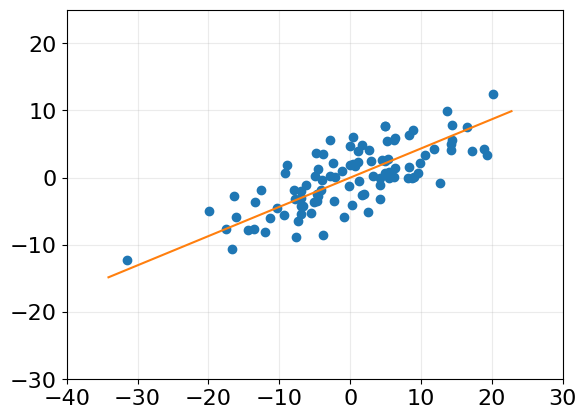

In [84]:
fig, ax = plt.subplots()

ax.plot(np.array(Y)[:, 0], np.array(Y)[:, 1], linestyle="None", marker="o")

xlim = ax.get_xlim()
x_space = np.linspace(xlim[0], xlim[1], 2)
y_space = x_space*first_ax[1]/first_ax[0]
ax.plot(x_space, y_space)

ax.set_xlim([-40, 30])
ax.set_ylim([-30, 25])

ax.grid("on")
plt.show(fig)
